In [1]:
######################
# LIBRARIES DOWNLOAD #
######################

install_packages = False
if install_packages:
    %pip install pandas tqdm numpy matplotlib pyspark dask

In [2]:
####################
# LIBRARIES IMPORT #
####################

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib as mpl
import dask.dataframe as dd
import time

In [3]:
#####################
# GLOBAL PARAMETERS #
#####################

chunk_size = 10000 # 10000

# Loading the data into Pandas' Dataframe

The dataset provided is composed of a "lighter_authors.json" file of about 0.5 Gbs and a "lighter_books.json" file of about 15 Gbs. Considering that where will be a data-type conversion the dataset will become even bigger when loaded on pandas and they could not work on machines with limited amounts of RAM. We can approach this problem from two sides:
* Divide the dataset in chunks, work one chunk at a time and merge the result.
* For every request we could extract only the columns we are interested with.

Both this approach are slow, we have to load every part of the dataset from the storage and load it on RAM for every exercise, and this increase considerably the amount of time to execute each query. Instead we try to load everything all at once, making the dataset lighter by removing columns useless for our analysis and where possible changing the data-type of useful columns to lighter versions.

## Authors dataset

In [4]:
# load the dataset from the .json file to a pandas dataframe
authors = pd.read_json("datasets/lighter_authors.json", lines = True)

In [4]:
# check the first lines of the dataframe
authors.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.79,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.60,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


In [6]:
# check some infos about each column
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351767 entries, 0 to 351766
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351767 non-null  int64  
 1   average_rating      351767 non-null  float64
 2   text_reviews_count  351767 non-null  int64  
 3   work_ids            351767 non-null  object 
 4   book_ids            351767 non-null  object 
 5   works_count         351767 non-null  int64  
 6   id                  351767 non-null  int64  
 7   name                351767 non-null  object 
 8   gender              351767 non-null  object 
 9   image_url           351767 non-null  object 
 10  about               351767 non-null  object 
 11  fans_count          351767 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.2+ MB


In [7]:
# check some infos about the RAM usage of every column
raw_authors_memory_usage = authors.memory_usage(index = True, deep = True)
raw_authors_memory_usage

Index                       132
ratings_count           2814136
average_rating          2814136
text_reviews_count      2814136
work_ids               74732848
book_ids               74732848
works_count             2814136
id                      2814136
name                   26225127
gender                 21473021
image_url              44826054
about                 410897820
fans_count              2814136
dtype: int64

In [8]:
print("The dataset just as imported uses", round(raw_authors_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'about' column covers", round(raw_authors_memory_usage["about"] / raw_authors_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.62 GBs of RAM!
The 'about' column covers 61.0 % of the total RAM usage alone!


The columns "image_url" and "about" are useless for our analysis so they can be removed.

In [5]:
# remove the useless columns
authors.drop(columns = ["image_url", "about"], inplace = True)
print("The dataset now uses", round(authors.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.2 GBs of RAM!


[TODO] CHANGE DATA TYPES?

## Books

The books dataset is much bigger than the authors one and we can't work with it in one go, we have to separate it in chunks. Firstly we analyze what can be done with it by only observing some rows

In [6]:
# load a chunk of the dataset from the .json file to a pandas dataframe
books = pd.read_json("datasets/lighter_books.json", lines = True, nrows = 100000)

In [60]:
# check the first lines of the chunk
books.head()

,id,title,authors,author_name,author_id,work_id,isbn,isbn13,asin,language,...,format,edition_information,image_url,publisher,num_pages,series_id,series_name,series_position,shelves,description
0,2,Harry Potter and the Order of the Phoenix (Har...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2809203,0439358078,9780439358071,,eng,...,Paperback,US Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,870,45175,Harry Potter,5,"[{'name': 'to-read', 'count': 324191}, {'name'...",There is a door at the end of a silent corrido...
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,4640799,,,,eng,...,Hardcover,Library Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc,309,45175,Harry Potter,1,"[{'name': 'fantasy', 'count': 63540}, {'name':...",Harry Potter's life is miserable. His parents ...
2,4,Harry Potter and the Chamber of Secrets (Harry...,None,J.K. Rowling,1077326,6231171,0439554896,9780439554893,,eng,...,Hardcover,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,352,45175,Harry Potter,2,"[{'name': 'to-read', 'count': 282341}, {'name'...",The Dursleys were so mean and hideous that sum...
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2402163,043965548X,9780439655484,,eng,...,Mass Market Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,435,45175,Harry Potter,3,"[{'name': 'to-read', 'count': 292815}, {'name'...","For twelve long years, the dread fortress of A..."
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,3046572,,,,eng,...,Paperback,First Scholastic Trade Paperback Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,734,45175,Harry Potter,4,"[{'name': 'to-read', 'count': 287086}, {'name'...",Harry Potter is midway through his training as...


In [61]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99984 entries, 0 to 99983
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         99984 non-null  int64  
 1   title                      99984 non-null  object 
 2   authors                    34259 non-null  object 
 3   author_name                99984 non-null  object 
 4   author_id                  99984 non-null  int64  
 5   work_id                    99984 non-null  int64  
 6   isbn                       99984 non-null  object 
 7   isbn13                     99984 non-null  object 
 8   asin                       99984 non-null  object 
 9   language                   99984 non-null  object 
 10  average_rating             99984 non-null  float64
 11  rating_dist                99984 non-null  object 
 12  ratings_count              99984 non-null  int64  
 13  text_reviews_count         99984 non-null  int

In [13]:
# check some infos about the RAM usage of every column
raw_books_memory_usage = books.memory_usage(index = True, deep = True)
raw_books_memory_usage

Index                             132
id                             799872
title                         9527837
authors                       4429384
author_name                   7210866
author_id                      799872
work_id                        799872
isbn                          6685027
isbn13                        6977966
asin                          5899280
language                      5953621
average_rating                 799872
rating_dist                   9376573
ratings_count                  799872
text_reviews_count             799872
publication_date              6517110
original_publication_date     6376536
format                        6521053
edition_information           6036222
image_url                    14857881
publisher                     7072478
num_pages                     4152804
series_id                     5989979
series_name                   6368140
series_position               5887790
shelves                      45721280
description 

In [14]:
print("The dataset just as imported uses", round(raw_books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'about' column covers", round(raw_books_memory_usage["description"] / raw_books_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.25 GBs of RAM!
The 'about' column covers 34.0 % of the total RAM usage alone!


The scenario is similar to the authors dataset, there is a column of long text descriptions that occupy a large amount of memory and it's useless to us. We remove it together with other useless columns such as "image_url", "isb", "isbn13", "asin" [TODO].

In [15]:
# remove the useless columns
books.drop(columns = ["isbn", "isbn13", "asin", "edition_information", "publisher", "image_url", "description", "shelves"], inplace = True)
print("The dataset now uses", round(books.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.08 GBs of RAM!


Now we try to load the whole books dataset, chunk by chunk, and removing the useless parts.

In [ ]:
books = pd.DataFrame()

chunks_number = np.ceil(7027431 / chunk_size)
chunks = pd.read_json("datasets/lighter_books.json", lines = True, chunksize = chunk_size)
columns_to_drop = ["author_name", "isbn", "isbn13", "asin", "edition_information", "image_url", "publisher", "shelves", "description"]

for chunk in tqdm(chunks, total = chunks_number):
    chunk.drop(columns = columns_to_drop, inplace = True)
    books = pd.concat([books, chunk])

  0%|          | 0/71.0 [00:00<?, ?it/s]

In [ ]:
# check some infos about each column
books.info()

In [ ]:
# check some infos about the RAM usage of every column
books_memory_usage = books.memory_usage(index = True, deep = True)
books_memory_usage

In [ ]:
print("The dataset uses", round(books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")

# Research questions [RQs]

## [RQ1] Exploratory Data Analysis (EDA)

TODO

In the Authors dataset what's the difference between "book" and "work"?

The Books dataset has some void string entries in the num_pages column.

Negative average ratings and ratings count and fans count.

# Analyze authors

In [6]:
authors.describe()

,ratings_count,average_rating,text_reviews_count,works_count,id,fans_count
count,3.517670e+05,351767.000000,351767.000000,3.517670e+05,3.517670e+05,351767.000000
mean,4.770586e+03,3.651194,330.993243,2.593714e+01,7.751861e+06,111.615731
std,9.769395e+04,1.211482,3857.539191,3.066083e+03,6.578409e+06,2661.018139
min,-4.100000e+01,-31.000000,0.000000,0.000000e+00,4.000000e+00,-33.000000
25%,6.000000e+00,3.600000,1.000000,2.000000e+00,1.535315e+06,1.000000
50%,3.900000e+01,3.950000,8.000000,6.000000e+00,6.470396e+06,4.000000
75%,3.100000e+02,4.250000,53.000000,1.500000e+01,1.434041e+07,20.000000
max,2.700375e+07,5.000000,608956.000000,1.775176e+06,2.124802e+07,766035.000000


In [7]:
l=[]
for i in range(len(authors['average_rating'])):
    if authors['average_rating'][i]<0:
        print(i)
        l.append(i)
    if authors['ratings_count'][i]<0:
        print(i) 
        l.append(i)
    if authors['fans_count'][i]<0:
        print(i)
        l.append(i)
        
l        

104296
129604
253327
253327
264572
264606
264611
264638
264743
264747
264859
264876
264878
264919
265036
265152
270664
274931
274940
275034
275039
275082
282878
285757
286226
337953
338249
343284


[104296,
 129604,
 253327,
 253327,
 264572,
 264606,
 264611,
 264638,
 264743,
 264747,
 264859,
 264876,
 264878,
 264919,
 265036,
 265152,
 270664,
 274931,
 274940,
 275034,
 275039,
 275082,
 282878,
 285757,
 286226,
 337953,
 338249,
 343284]

In [8]:
l = list(set(l))
l

[275082,
 253327,
 286226,
 264859,
 264606,
 337953,
 264611,
 264743,
 264747,
 264876,
 264878,
 264572,
 285757,
 264638,
 265152,
 129604,
 270664,
 338249,
 265036,
 264919,
 275034,
 275039,
 104296,
 274931,
 343284,
 274940,
 282878]

In [9]:
for i in l:
    authors= authors.drop(i)
    
authors.describe()    

,ratings_count,average_rating,text_reviews_count,works_count,id,fans_count
count,3.517400e+05,351740.000000,351740.000000,3.517400e+05,3.517400e+05,351740.000000
mean,4.770952e+03,3.651283,331.018414,2.593874e+01,7.751783e+06,111.624663
std,9.769769e+04,1.210085,3857.686173,3.066201e+03,6.578581e+06,2661.120073
min,0.000000e+00,0.000000,0.000000,0.000000e+00,4.000000e+00,0.000000
25%,6.000000e+00,3.600000,1.000000,2.000000e+00,1.534690e+06,1.000000
50%,3.900000e+01,3.950000,8.000000,6.000000e+00,6.470274e+06,4.000000
75%,3.100000e+02,4.250000,53.000000,1.500000e+01,1.434083e+07,20.000000
max,2.700375e+07,5.000000,608956.000000,1.775176e+06,2.124802e+07,766035.000000


now there no 'strange' values and ratings_count, average_rating and fans_count have not any outlier

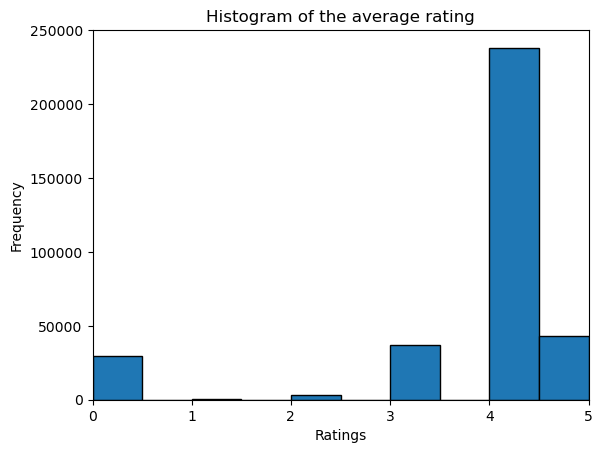

<Figure size 500x500 with 0 Axes>

In [10]:
#hist of the average ratings of all the authors
import matplotlib.pyplot as plt 
plt.hist(round(authors.average_rating), bins=10, edgecolor='black')
plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating')
plt.figure(figsize=(5, 5))
plt.show()

As we can see there are a lot of ratings with values from 4.0 to 5.0 and only a small part with rating values from 1.0 to 3.0

In [ ]:
#plot of the works_count of all the authors
import matplotlib.pyplot as plt 
plt.bar(authors.name, authors.works_count, color='skyblue')

#plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating')
plt.figure(figsize=(5, 5))
plt.show()


KeyboardInterrupt



In [ ]:
from sklearn.preprocessing import StandardScaler

X = authors[["average_rating"]]
Y = authors[["ratings_count"]]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
Y_standardized = scaler.fit_transform(Y)

df_standardized = pd.DataFrame({"X_standardized": X_standardized.flatten(), "Y_standardized": Y_standardized.flatten()})

plt.scatter(df_standardized["X_standardized"], df_standardized["Y_standardized"], color='blue', marker='o')

plt.title('Plot: average_rating and ratings_count')
plt.xlabel('average_rating')
plt.ylabel('ratings_count')
plt.grid(True)


plt.show()


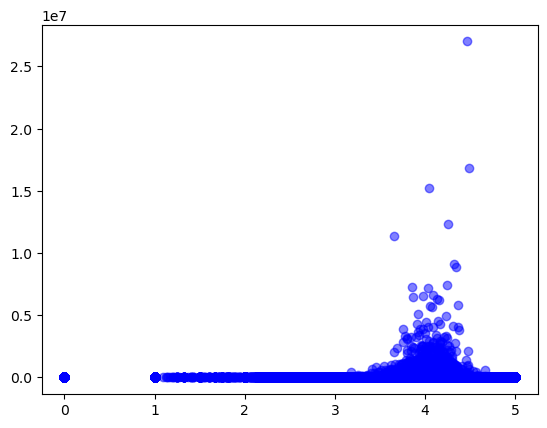

0.015256399747704081


In [51]:
plt.scatter(authors['average_rating'] ,authors['ratings_count'], color='blue', marker='o',alpha=0.5)#scatterplot of average ratings and rating count
plt.show()
print(authors['average_rating'].corr(authors['ratings_count']))  #correlation between average ratings and rating count

The correlation between average ratings and rating count is very close to 0, that indicates that there is no relationship between the two variables.

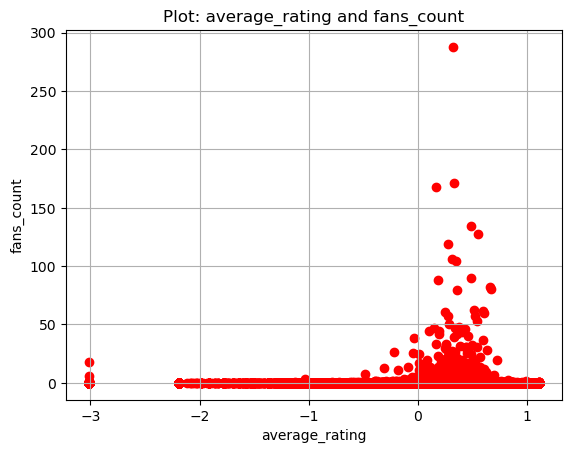

0.012478842829977509


In [57]:
X = authors[["average_rating"]]
Y = authors[["fans_count"]]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
Y_standardized = scaler.fit_transform(Y)

df_standardized = pd.DataFrame({"X_standardized": X_standardized.flatten(), "Y_standardized": Y_standardized.flatten()})

plt.scatter(df_standardized["X_standardized"], df_standardized["Y_standardized"], color='red', marker='o')

plt.title('Plot: average_rating and fans_count')
plt.xlabel('average_rating')
plt.ylabel('fans_count')
plt.grid(True)


plt.show()

correlation = df_standardized['X_standardized'].corr(df_standardized['Y_standardized'])
print(correlation)

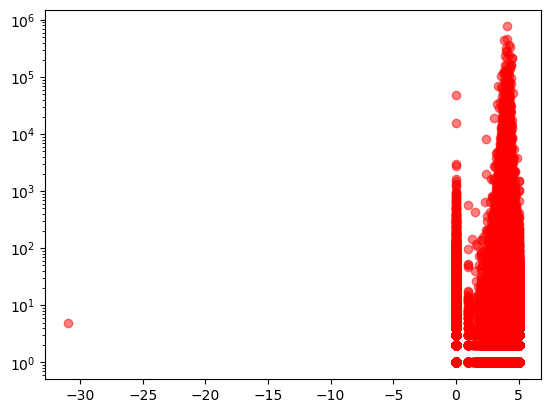

0.012466818186120887


In [24]:
plt.scatter(authors.average_rating, authors.fans_count, color='red', marker='o', alpha=0.5)

plt.show()

print(authors['average_rating'].corr(authors['fans_count']))

The correlation between average ratings and fans count is very close to 0, that indicates that there is no relationship between the two variables.

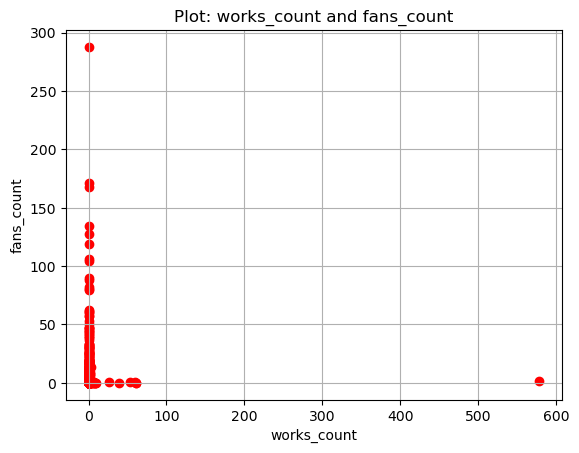

0.005022755324341809


In [59]:
X = authors[["works_count"]]
Y = authors[["fans_count"]]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
Y_standardized = scaler.fit_transform(Y)

df_standardized = pd.DataFrame({"X_standardized": X_standardized.flatten(), "Y_standardized": Y_standardized.flatten()})

plt.scatter(df_standardized["X_standardized"], df_standardized["Y_standardized"], color='red', marker='o')

plt.title('Plot: works_count and fans_count')
plt.xlabel('works_count')
plt.ylabel('fans_count')
plt.grid(True)


plt.show()

correlation = df_standardized['X_standardized'].corr(df_standardized['Y_standardized'])
print(correlation)

The correlation between works count and fans count is very close to 0, that indicates that there is no relationship between the two variables.

# Analize books

In [62]:
books.describe()

,id,author_id,work_id,average_rating,ratings_count,text_reviews_count
count,99984.000000,9.998400e+04,9.998400e+04,99984.000000,9.998400e+04,99984.000000
mean,84819.740098,6.843063e+05,2.858894e+06,3.827090,4.522036e+04,1253.207613
std,51714.990145,2.315750e+06,9.421976e+06,0.692622,2.658542e+05,5678.835099
min,2.000000,4.000000e+00,6.200000e+01,0.000000,0.000000e+00,0.000000
25%,39873.750000,7.419000e+03,8.251775e+04,3.710000,5.800000e+01,5.000000
50%,82298.500000,2.418600e+04,1.683725e+05,3.930000,5.910000e+02,41.000000
75%,128059.250000,7.098400e+04,1.716845e+06,4.130000,5.843000e+03,302.000000
max,180140.000000,2.097942e+07,8.972161e+07,5.000000,7.377351e+06,116930.000000


In [7]:
books['id']

0             2
1             3
2             4
3             5
4             6
          ...  
99979    180123
99980    180136
99981    180137
99982    180139
99983    180140
Name: id, Length: 99984, dtype: int64

In [8]:
books['author_id']

0        1077326
1        1077326
2        1077326
3        1077326
4        1077326
          ...   
99979     104978
99980       5627
99981       5627
99982       5627
99983       5627
Name: author_id, Length: 99984, dtype: int64

In [11]:
books['authors']

0        [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...
1        [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...
2                                                     None
3        [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...
4        [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...
                               ...                        
99979                                                 None
99980    [{'id': '5627', 'name': 'Anthony Robbins', 'ro...
99981                                                 None
99982                                                 None
99983                                                 None
Name: authors, Length: 99984, dtype: object

In [12]:
books['author_name']

0               J.K. Rowling
1               J.K. Rowling
2               J.K. Rowling
3               J.K. Rowling
4               J.K. Rowling
                ...         
99979    Michael Linenberger
99980        Anthony Robbins
99981        Anthony Robbins
99982        Anthony Robbins
99983        Anthony Robbins
Name: author_name, Length: 99984, dtype: object

it looks like there are no 'strange' values in the dataset

## [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:

**Request 2.1: Plot the number of books for each author in descending order.**

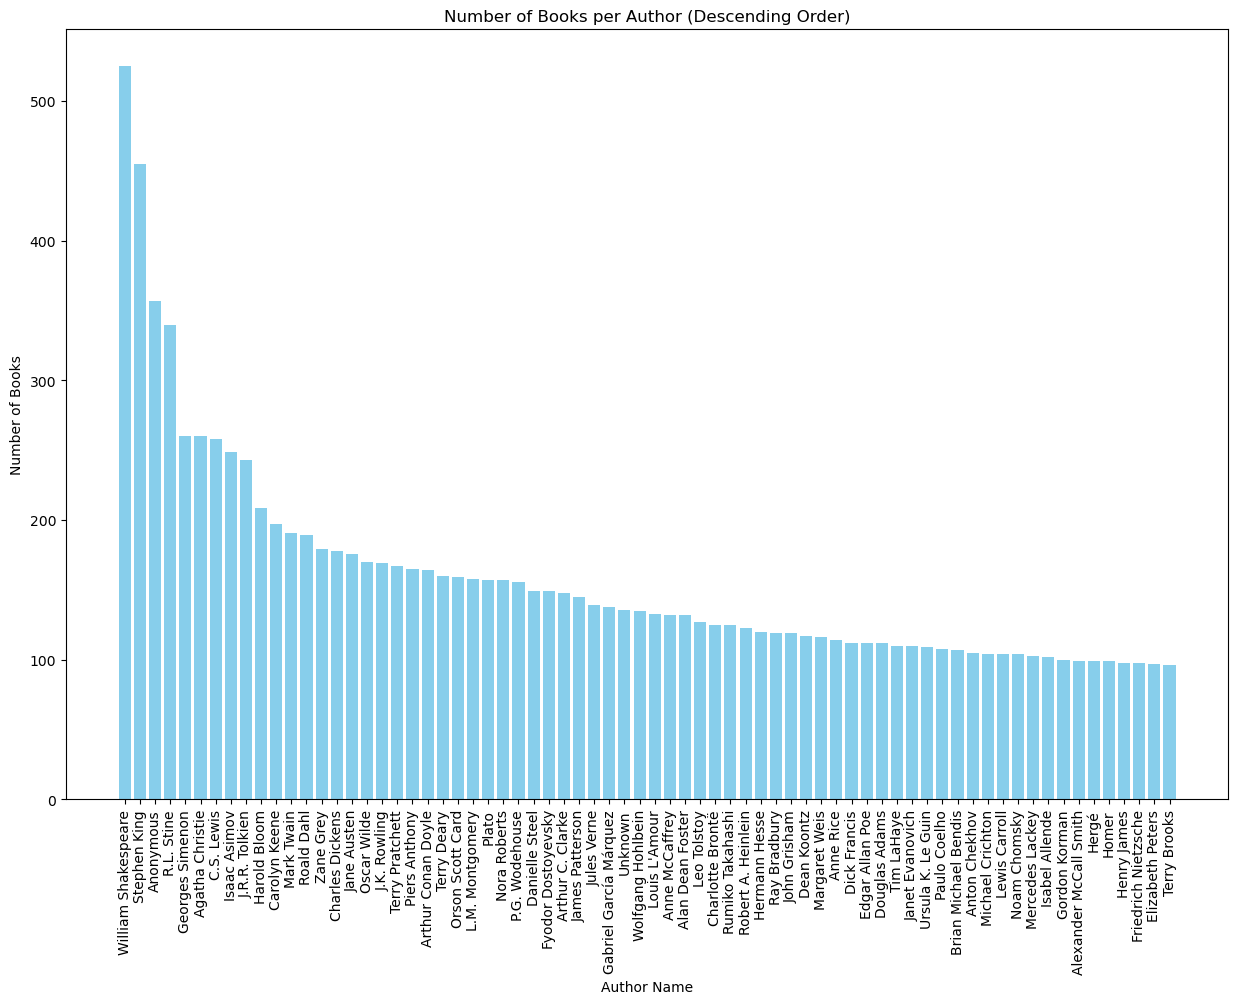

In [35]:
import matplotlib.pyplot as plt

counts = books['author_name'].value_counts().sort_values(ascending=False).head(70)

plt.figure(figsize=(15, 10))
plt.bar(counts.index, counts.values, color='skyblue')
plt.title('Number of Books per Author (Descending Order)')
plt.xlabel('Author Name')
plt.ylabel('Number of Books')
plt.xticks(rotation=90)
plt.show()

**Request 2.2:  Which book has the highest number of reviews?**

In [ ]:
books[books["text_reviews_count"] >= max(books["text_reviews_count"])]

**Request 2.3: Which are the top ten and ten worst books concerning the average score?**

In [ ]:
books.nlargest(10, "average_rating")

In [ ]:
books.nsmallest(10, "average_rating")

**Request 2.4: Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.**

In [ ]:
languages = books['language'].value_counts() 
languages.plot(kind="bar", color='blue')

**Request 2.5: How many books have more than 250 pages?**

Notice that there are some entries that have a void string instead of the number of pages.

In [ ]:
# create a view that excludes the entries with void string
df = books[books["num_pages"] != ""]

# execute query
result = df[df["num_pages"].astype(int) > 250].shape[0]

print(result)

**Request 2.6: Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).**

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'NOT A BOOK'),
  Text(1, 0, 'Jesse Russell'),
  Text(2, 0, 'Ronald Cohn'),
  Text(3, 0, 'Anonymous'),
  Text(4, 0, 'Unknown'),
  Text(5, 0, 'Source Wikipedia'),
  Text(6, 0, 'Various'),
  Text(7, 0, 'Philip M. Parker'),
  Text(8, 0, 'U.S. Congress'),
  Text(9, 0, 'Books LLC'),
  Text(10, 0, 'Livres Groupe'),
  Text(11, 0, 'Walt Disney Company'),
  Text(12, 0, 'National Aeronautics and Space Administration'),
  Text(13, 0, 'Source Wikia'),
  Text(14, 0, 'U.S. House of Representatives'),
  Text(15, 0, 'Fuente Wikipedia'),
  Text(16, 0, 'William Shakespeare'),
  Text(17, 0, 'Organisation for Economic Co-operation and Development'),
  Text(18, 0, 'Arthur Conan Doyle'),
  Text(19, 0, 'McGraw-

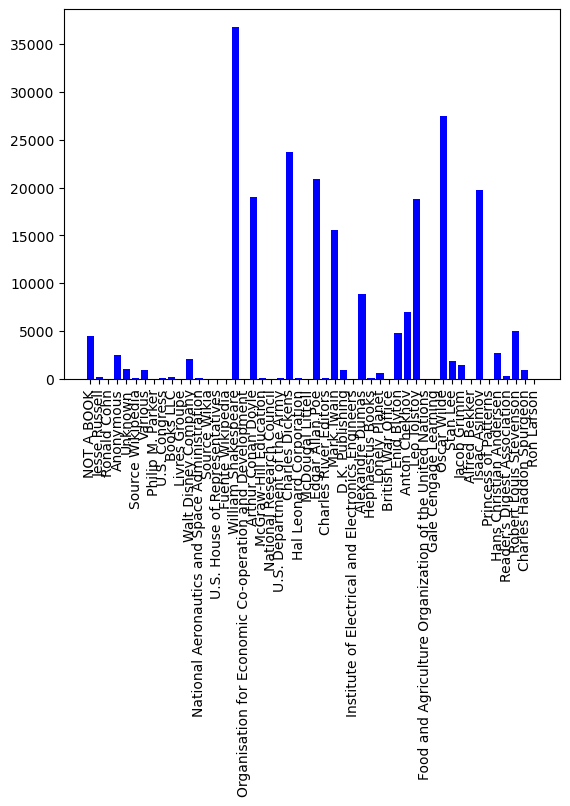

In [38]:
top_authors = authors.sort_values(by="works_count", ascending=False).head(50)
plt.bar(top_authors["name"], top_authors["fans_count"], color='blue')
plt.xticks(rotation=90)

## [RQ3] Let’s have a historical look at the dataset!

**Request 3.1: Write a function that takes as input a year and returns as output the following information:**

* **The number of books published that year.**
* **The total number of pages written that year.**
* **The most prolific month of that year.**
* **The longest book written that year.**

**We have to cope on the number of pages, how do we work in this case?**

In [36]:
#TODO

def look_by_year(books, year):
    books_year = books["original_publication_date" == year]
    n_books = books_year.shape[0]

    tot_pages = sum(books_year["num_pages"]) #todo
    publications_count = books_year.groupby("title")["publication_date"].nunique()
    prolific_month = max(publications_count) #non so come mettere il mese
    longest_book = books_year.max(tot_pages) 

    return n_books, tot_pages, prolific_month, longest_book

## [RQ4] Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

**Request 4.1: You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?**

In [ ]:
authors[(authors["name"] == authors["name"]) & (authors["id"] != authors["id"])]

## [RQ5] We can consider the authors with the most fans to be influential. Let’s have a deeper look.

## [RQ6] For this question, consider the top 10 authors concerning the number of fans again.

## [RQ7] Estimating probabilities is a core skill for a data scientist: show us your best!

## [RQ8] Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

# Bonus points

## 1

**Request 1.1: Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload authors.json dataset, and filter authors with at least 100 reviews. Do the same using Pandas and compare performance in terms of milliseconds.**

In [ ]:
authors_path = r"D:\Data Science\ADM\Datasets\Books metadata dataset\archive\authors.json\authors.json"

chunks_number = np.ceil(7374310 / chunk_size)
columns_to_drop = ["about", "image_url"]

# with reviews is it meant text reviews or ratings?

authors = pd.DataFrame()
chunks = pd.read_json(authors_path, lines = True, chunksize = chunk_size)

for chunk in tqdm(chunks, total = chunks_number):
    chunk.drop(columns = columns_to_drop, inplace = True)
    authors = pd.concat([authors, chunk])

In [ ]:
# IN PANDAS

print("Measuring Pandas performance...")
%timeit authors[authors["text_reviews_count"] >= 100]

# IN DASK

authors_dask = dd.from_pandas(authors, npartitions = 1)

print("Measuring Dask performance...")
%timeit authors_dask[authors_dask["text_reviews_count"] >= 100].compute()

**Request 1.2: Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload books.json, and join them with authors.json based on author_id. How many books don’t have a match for the author?**

TODO

In [ ]:
books_path = r"D:\Data Science\ADM\Datasets\Books metadata dataset\archive\books.json"

chunks_number = np.ceil(7374310 / chunk_size)
columns_to_keep = ["id", "author_id"]

books = pd.DataFrame()
chunks = pd.read_json(books_path, lines = True, chunksize = chunk_size)

for chunk in tqdm(chunks, total = chunks_number):
    chunk = chunk[columns_to_keep]
    books = pd.concat([books, chunk])

books.shape

## 2 Every book should have a field named description, and any author should have a field named description. Choose one of the two and perform a text-mining analysis:

**Request 2.1: If you choose to text-mine books.json ’ descriptions, try to find a way to group books in genres using whatever procedure you want, highlighting words that are triggers for these choices.**

TODO

**Request 2.2: If you choose to text-mine authors.json’ about-field, try to find a way to group authors in genres using whatever procedure you want, highlighting words that are triggers for these choices.**

TODO

**Request 2.3: If you feel comfortable and did both tasks, analyze the matching of the two procedures. You grouped books and authors in genres. Do these two procedures show correspondence?**

TODO

# Command Line Question (CLQ)

Using the command line is a feature that Data Scientists must master. It is relevant since the operations there require less memory to use in comparison to other interfaces. It also uses less CPU processing time than other interfaces. In addition, it can be faster and more efficient and handle repetitive tasks quickly.

Note: To answer the question in this section, you must strictly use command line tools. We will reject any other method of response.

Looking through the files, you can find series.json, which contains a list of book series. In each series's 'works' field, you'll find a list of books that are part of that series. Report the title of the top 5 series with the highest total 'books_count' among all of their associated books using command line tools.

1. Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]

2. Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

The expected result is as follows:

| id    | title                                | total_books_count |
|-------|--------------------------------------|-------------------|
| 302380| Extraordinary Voyages                | 20138             |
| 94209 | Alice's Adventures in Wonderland     | 14280             |
| 311348| Kolekcja Arcydzieł Literatury Światowe| 13774             |
| 41459 | Oz                                   | 11519             |
| 51138 | Hercule Poirot                       | 11305             |


**Request 1: Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]**

The shell script file *commandline_original.sh* is implemented as requested and the output correspond to what it's expected, the only difference we find it's the transformation of special characters like 'Ś' in 'Światowe' to their unicode counterpart, as '\u015'. Comment on the code is inside the file itself but we briefly describe the code here: for each line of the json file we extract 'id' and 'title' of the series and than the whole "works" subsection using Regexs. From the "works" subsection we search every field 'work_counts', sum the value, store it in an accumulator and append everything in a list. After having gone through every line of the json file we sort the list using only the total work counts field and using a for cycle print the first five results following the format of the table shown.

**Request 2: Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.**

We tried to use ChatGPT 3.5 to implement a more robust script implementation that is also at most three lines. This is the prompt sent:

```
You have to write a more robust implementation of the given bash code. Your implementation must be at most three lines long. You can't use jq.
[original sh code here]
```

We explicitely said not to use jq to avoid using external libraries. The result is stored in *commandline_LLM.sh* and it doesn't work. We can immediately see it from the different output and the fact that in the source code it's never mentioned the field "books_count". We also tried to use alternative LLMs chatbots like Bing with similar results. Removing the costraint of using only three lines the results become correct but also extremely similar to the original code. Meanwhile giving only the text of the question does not bring positive results.

# AWS Question (AWSQ)

AWS offers access to many cloud-based tools and services that simplify data processing, storage, and analysis. Thanks to AWS's scalable and affordable solutions, data scientists can work effectively with large datasets and carry out advanced analytics. A data scientist must, therefore, perform the essential task of learning how to use AWS. To complete a straightforward data analysis task in this question, you must set up an environment on Amazon Web Services.

In this question, you are asked to provide the most commonly used tags for book lists. Going through the list.json file, you'll notice that each list has a list of tags attached, and we want to see what are the most popular tags across all of the lists. Please report the top 5 most frequently used tags and the number of times they appear in the lists.

You have to follow the following (recommended) steps:

* Download the list.json file to your local system.
* Write a Python script that generates the report and the system's time to generate it.
* Set up an EC2 instance on your AWS account and upload the list.json file together with your script to the instance
* Compare the running times of your script on your local system and the EC2 instances.

**Important note:** Please run the same script on both your local system and your EC2 instance to compare the results. e.g., * keep the parameters the same if you are processing the data by loading it partially and aggregating the results. Comment about the differences you find.

Please provide a report as follows:

* The information about the config of the EC2 instance
* The command used to connect to the EC2
* The commands used to upload the files and run the script on the EC2 instance through your local system
* A table containing the most popular tags and their number of usage
* A table containing the running time of the script on your local system and EC2 instance

The following is the expected outcome for the most popular tags:

|     Tag            |   # Usage   |
|--------------------|------------|
| romance            |     6001    |
| fiction            |     5291    |
| young-adult        |     5016    |
| fantasy            |     3666    |
| science-fiction    |     2779    |

TODO

# Algorithmic Question (AQ)

Assume you are working as a librarian at a public library in Rome. Some new books have arrived, and you are in charge of putting them on a shelf. Your supervisor will give you some instructions, and you will follow his. Each book has a unique ID, and your boss's instructions can be of the following types:

* L N - place the book with ID = N on the shelf to the left of the leftmost existing book
* R N - place the book with ID = N on the shelf to the right of the rightmost existing book
* ? N - Calculate the minimum number of books you must pop from the left or right to have the book with ID = N as the leftmost or rightmost book on the shelf.

You must follow your boss's instructions and report the answers to type 3 instructions to him. He guarantees that if he has a type 3 instruction for a book with a specific ID, the book has already been placed on the shelf.

Remember that once you've answered a type 3 instruction, the order of the books does not change.

**Input:**

The first line contains a single number, n, representing the number of your boss's instructions. The ith instruction the boss gives can be found at each of the following n lines.

**Output:**

Print your boss's type 3 instructions in the order they appear in the input.

**Examples:**

Input 1
```
L 75
R 20
R 30
L 11
? 75
L 12
L 15
? 20
```

Output 1
```
1
1
```

Input 2
```
R 1
L 2
L 3
L 4
? 3
R 5
R 6
L 7
L 8
? 4
L 9
R 10
R 11
L 12
L 13
? 11
? 3
```

Output 2:
```
1
2
0
6
```

1. Implement a code to answer the problem above.

2. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Do you believe this is correct? How can you double-check it? Elaborate about your answer.

3. Is the algorithm proposed in (1.) the optimal one to produce the required output? If not, can you suggest a better algorithm to perform the same task?

In [ ]:
# Request 1: Implement a code to answer the problem above.

def algorithmic_question(input_string):
    input_list = input_string.split("\n")
    n_commands = int(input_list.pop(0))

    shelf = []
    output = []
    for i in range(n_commands):
        command = input_list[i].split(" ")
        if command[0] == "L":
            shelf = [command[1]] + shelf
        elif command[0] == "R":
            shelf = shelf + [command[1]]
        elif command[0] == "?":
            index = shelf.index(command[1])
            result = min(index, (len(shelf) - 1) - index)
            output.append(result)

    print(*output, sep = "\n")
    return
 
input1 = "8\nL 75\nR 20\nR 30\nL 11\n? 75\nL 12\nL 15\n? 20\n"
print("Test1:")
algorithmic_question(input1)


input2 = "17\nR 1\nL 2\nL 3\nL 4\n? 3\nR 5\nR 6\nL 7\nL 8\n? 4\nL 9\nR 10\nR 11\nL 12\nL 13\n? 11\n? 3\n"
print("\nTest2:")
algorithmic_question(input2)

**Request 2: Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Do you believe this is correct? How can you double-check it? Elaborate about your answer.**

TODO

**Request 3: Is the algorithm proposed in (1.) the optimal one to produce the required output? If not, can you suggest a better algorithm to perform the same task?**

TODO